```
title: "barber-cushman.rmd"
author: "Johannes Postma" (with slight adaptations by Andrea Schnepf)
date: "May 14, 2018"
output: 
  pdf_document:
     latex_engine: xelatex
license: gpl
```

In [12]:
knitr::opts_chunk$set(echo = TRUE)

## Baber-Cushman model 

Itoh S, Barber SA. 1983. A numerical solution of whole plant nutrient uptake for soil-root systems with root hairs. Plant and Soil 70: 403-413.

requirements: the barber-cushman-onlineVersion0.1-function-library.r in the working dir of R

In [13]:
#load model functions
source("barber-cushman-onlineVersion0.32-function-library.r")


## Set parameters

In [14]:
#set parameter set
#param=roothairPublication1983
param=paramBarberBookP

#param is a list
str(param)

#change for example b
param$b=163


List of 20
 $ v0       : num 1e-07
 $ De       : num 2.3e-09
 $ b        : num 163
 $ Cli      : num 0.0136
 $ Imax     : num 3.21e-07
 $ Km       : num 0.00545
 $ E        : num 0
 $ Cmin     : num 2e-04
 $ r0       : num 0.05
 $ r1       : num 0.55
 $ k        : num 60
 $ small    : num 0.01
 $ dt       : num 0.1
 $ case     : num 2
 $ endtime  : num 30
 $ tcfactor : num 86400
 $ roothairs: num 1
 $ rh       : num 5e-04
 $ Nh       : num 1000
 $ lh       : num 0.2


## Run the model
The function barber returns the matrix m which contains for every position and time the concentration

In [15]:
#run model, m
m<-barber(param,msg="my test run")

[1] "my test run"


##Integrate

In [16]:
#integrate the results
res<-barberTotN(param,m)
names(res)

[1] "Nupt"     "Nupth"    "TNupt"    "TNupth"   "TotNupt"  "TotNupth"

##Plot results

##Run the classical barber sensitivity analysis

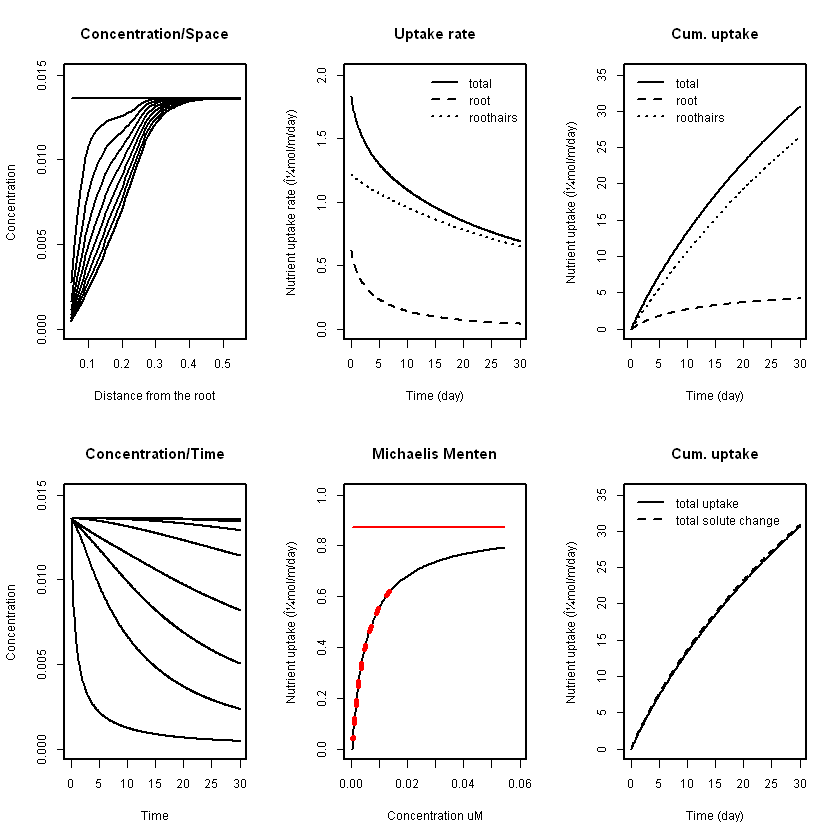

In [17]:
plotbarber<-function(param,m,filename="none"){
   #if(filename!="none") png(filename=paste(filename,".png"),width=1200,height=1200)
   if(filename!="none") svg(filename=paste(filename,".svg"),width=10,height=7)
   #calculate constants
   const<-setConstants(param)
   k=const$k
   dt=const$dt
   l=length(const$time)
   jm=l+1
   time=c(0,const$time*const$dt)
   fr=8 #number of lines per plot
   
   #unit
   unit=const$unit

   #calculate nutrient uptake
   data<-barberTotN(param,m)   

   #4 graphs
   oldpar=par(no.readonly=TRUE)
   par(mfcol=c(2,3),ps=11,lwd=2 ) #one graph with large text

   #plot the m matrix
   ylim=range(pretty(c(0,1.1*max(m))))
   plot(const$r,m[,l+1], main="Concentration/Space",xlab="Distance from the root",ylab="Concentration", type='l',ylim=ylim)
   a=as.integer(l/fr)
   for(i in c(1,(1:(l/a))*a)){
      lines(const$r,m[,i])
   }

   #plot the depletion 
   plot (time,m[1,], main="Concentration/Time",xlab="Time",ylab="Concentration", type='l', ylim=ylim) #plot
   a=as.integer(k/fr)
   for(i in c(1,(1:(k/a))*a)){
      lines(time,m[i,]) #plot
   }

   #plot the uptake rate by time
   sumNupt=100*(data$Nupt+data$Nupth)
   plot (time,sumNupt, main="Uptake rate",xlab="Time (day)",ylab=paste("Nutrient uptake rate (",unit,"/m/day)",sep=""), type='l', ylim=range(pretty(c(0,max(sumNupt))))) #plot
   lines(time,100*data$Nupt, lty=2)
   lines(time,100*data$Nupth, lty=3)
   legend("topright", legend = c("total","root","roothairs"),lty=c(1,2,3),bty='n')

   #plot the michaelis mente uptake curve
   crm=max(10*const$Km, 1.1*max(m))
   cr=seq(const$Cmin,crm,(crm-const$Cmin)/100) #concentration range
   vm=100*const$r0*pi*2*const$Imax/const$dt
   
   ylab=paste("Nutrient uptake (",unit,"/m/day)",sep="")
   plot(cr,100*MMuptake(const,cr), main="Michaelis Menten",xlab="Concentration uM",ylab=ylab, type='l',ylim=range(pretty(c(0,vm))), xlim=range(pretty(c(0,crm))) ) #plot
   lines(m[1,],100*data$Nupt,col=2,lty=3,lwd=4)
   lines(range(cr),c(vm,vm),col=2,lty=1,lwd=2)
   
   #plot uptake curves
   sumNupt=100*(data$TotNupt+data$TotNupth)
   plot (time,sumNupt, main="Cum. uptake",xlab="Time (day)",ylab=ylab, type='l', ylim=range(pretty(c(0,max(sumNupt))))) #plot
   lines(time,100*data$TotNupt, lty=2)
   lines(time,100*data$TotNupth, lty=3)
   legend("topleft", legend = c("total","root","roothairs"),lty=c(1,2,3),bty='n')

   #total change in mass ()
   #sumNupt=100*(data$TotNupt+data$TotNupth)
   dc=const$Cli - m #concentration change
   mv=sweep(dc,MARGIN=1,(const$b)*const$vol,`*`) #mulitply concentration with volume and buffer to get amounts
   dcs=100*colSums(mv)
   #dcs=100*colSums((mv[1:(k-1),]+mv[2:k,])/2) #spatial integration
   plot (time,sumNupt, main="Cum. uptake",xlab="Time (day)",ylab=ylab, type='l', ylim=range(pretty(c(0,max(sumNupt,dcs))))) #plot
   lines(time,dcs, lty=2)
   legend("topleft", legend = c("total uptake","total solute change"),lty=c(1,2),bty='n')
   
   
   par(oldpar)
   if(filename!="none") dev.off()

}
plotbarber(param,m)


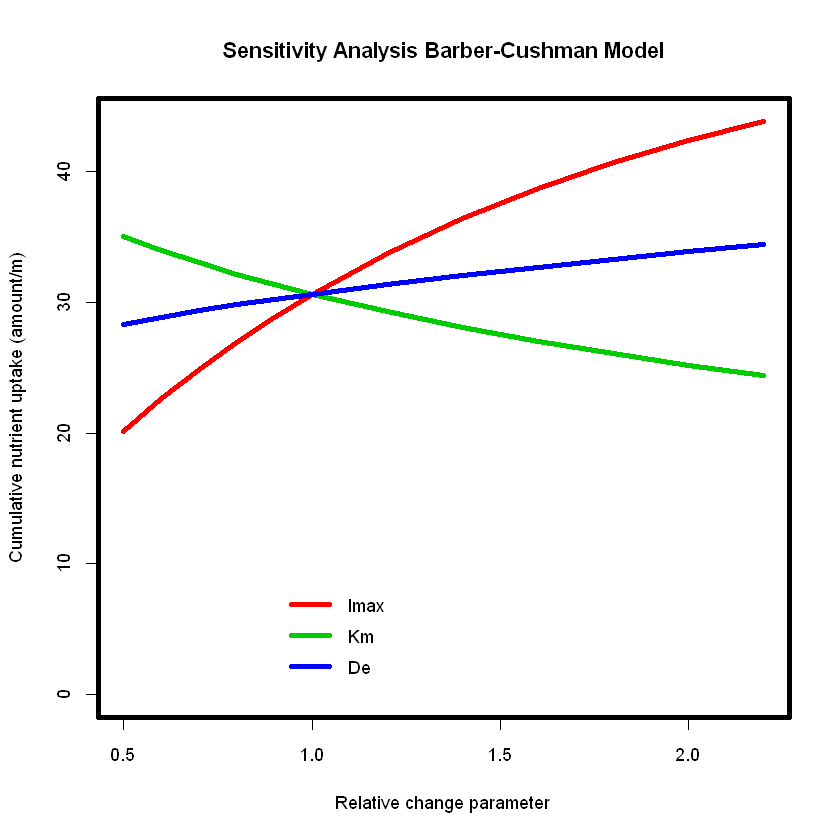

In [19]:
#do a sensitivity analysis (may take a long time, depending on the list or parameters!)
invisible(capture.output(dat<-sensitivityBarber(param, sensitivity_names=c("Imax","Km","De"))))
#(\"Cli\",\"r0\",\"r1\",\"Imax\",\"Km\",\"De\",\"b\",\"v0\",\"Imaxh\",\"lh\",\"rh\",\"Nh\",\"Nh~lh\"))
 plotSensitivityBarber(dat)